In [56]:
import pandas as pd 
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [57]:
# Pega o diretório onde o script está sendo executado
diretorio_atual = os.getcwd()
arquivos_json = [f for f in os.listdir(diretorio_atual) if f.endswith('.json')]

dfs = []

for i,arquivo in enumerate(arquivos_json):
    with open(os.path.join(diretorio_atual, arquivo), 'r') as f:
        data = json.load(f)
    
    parametros = {
        'neuronios_camada': data['neuronios_camada'],
        'neuronios_saida': data['neuronios_saida'],
        'epocas': data['epocas'],
        'taxa_aprendizado': data['taxa_aprendizado'],
        'camadas': data['camadas'],
        'bias': data['bias'],
        'tipo': data['tipo'],
        'ativacao': data['ativacao']
    }

    for metrica in data['metricas']:
        df = pd.json_normalize(metrica, 
                               record_path='erro_treinamento', 
                               meta=['fold', 'metrica_previsao'],  
                            #    meta_prefix='metrica_',  
                               errors='ignore')
        
        for param, value in parametros.items():
            df[param] = value
        df['id'] = i
        dfs.append(df)

df_final = pd.concat(dfs, ignore_index=True)   

In [58]:
df_final.head()

,epoca,erros_epoca,fold,metrica_previsao,neuronios_camada,neuronios_saida,epocas,taxa_aprendizado,camadas,bias,tipo,ativacao,id
0,0,0.044786,0,0.003805,3,1,100,0.05,2,0,regressao,tanh,0
1,1,0.039456,0,0.003805,3,1,100,0.05,2,0,regressao,tanh,0
2,2,0.038472,0,0.003805,3,1,100,0.05,2,0,regressao,tanh,0
3,3,0.037922,0,0.003805,3,1,100,0.05,2,0,regressao,tanh,0
4,4,0.037432,0,0.003805,3,1,100,0.05,2,0,regressao,tanh,0


In [59]:
df_reg = df_final[df_final['tipo']=='regressao']

## Analise por Neuronios de saida

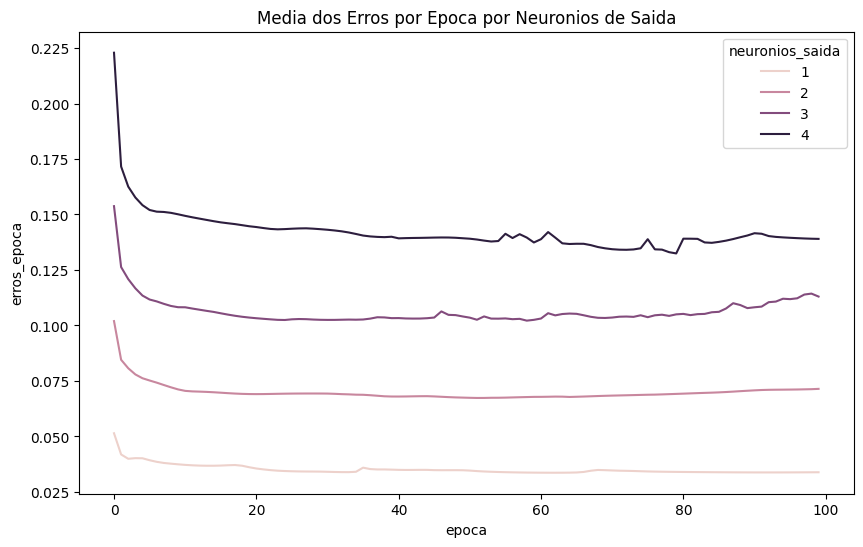

In [60]:
epocas = df_reg.groupby(['epoca','neuronios_saida'])['erros_epoca'].mean().reset_index()
plt.figure(figsize=[10,6])
sns.lineplot(epocas,x='epoca',y='erros_epoca',hue='neuronios_saida')
plt.title('Media dos Erros por Epoca por Neuronios de Saida')
plt.show()

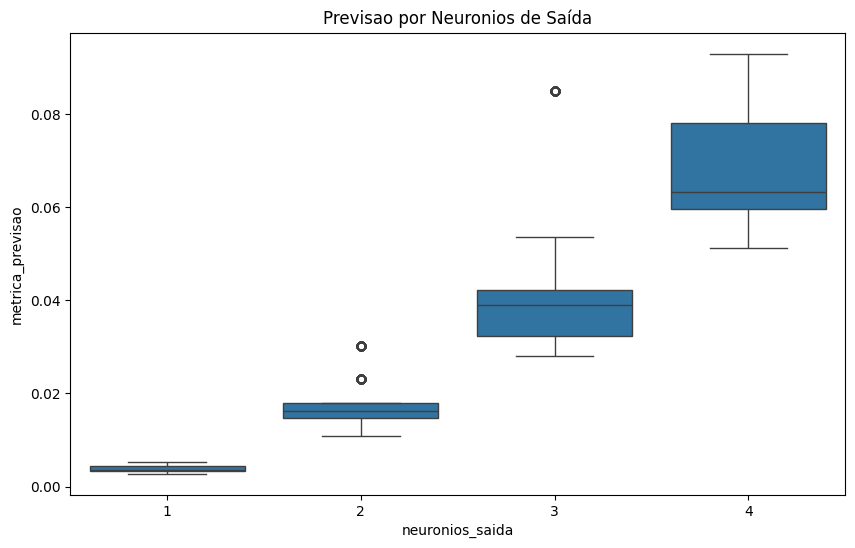

In [61]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_final, x='neuronios_saida', y='metrica_previsao')
plt.title('Previsao por Neuronios de Saída')
plt.show()

## Analise por numero de camadas

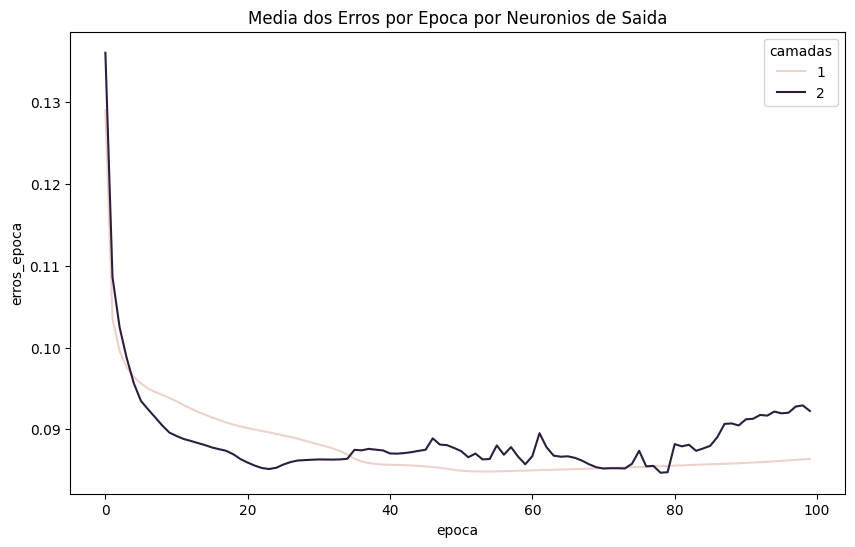

In [64]:
epocas = df_reg.groupby(['epoca','camadas'])['erros_epoca'].mean().reset_index()
plt.figure(figsize=[10,6])
sns.lineplot(epocas,x='epoca',y='erros_epoca',hue='camadas')
plt.title('Media dos Erros por Epoca por Neuronios de Saida')
plt.show()

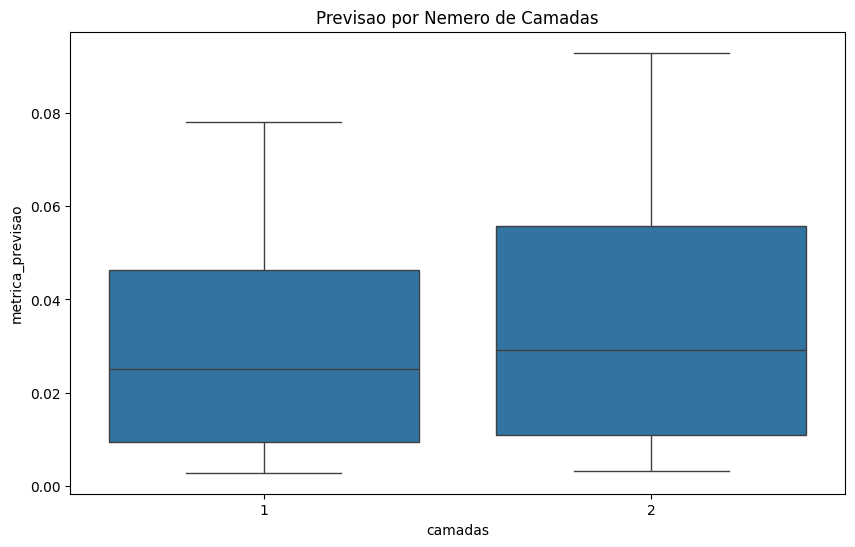

In [65]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_final, x='camadas', y='metrica_previsao')
plt.title('Previsao por Nemero de Camadas')
plt.show()